# NIPALS

- *Auteurs:* Quentin Grimonprez, Cristian Preda, Vincent Vandewalle
- *Date:* 3 février 2020

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = 8, 8
rng = np.random.default_rng(42)  # fixer le seed de l'aléa

## Simulation des données

In [2]:
n = 100
p = 4
mu = [1, 2, 4, 3]
cov = [[0.7, 0, 1.3, 0.5],
       [0, 1.2, -0.3, -0.1],
       [1.3, -0.3, 3.1, 1.3],
       [0.5, -0.1, 1.3, 0.6]]

X = rng.multivariate_normal(mu, cov, n)
X[:10, ]

array([[1.23188337, 3.14347085, 3.38747085, 2.78091498],
       [2.68390863, 3.01394039, 7.49967134, 4.42190575],
       [1.47854511, 2.8752649 , 3.94930934, 2.96519088],
       [0.88652465, 0.7900847 , 3.87468799, 2.70999804],
       [1.15626546, 3.07337384, 3.34086297, 2.58239614],
       [1.63844708, 2.6526894 , 4.28874731, 2.89878903],
       [1.57275728, 2.27116509, 4.70553025, 3.26809815],
       [1.31399837, 1.54228126, 3.15422406, 2.2028122 ],
       [1.77750098, 2.74133885, 4.80741826, 3.42503327],
       [0.97545041, 2.90650781, 4.23619526, 3.35994645]])

On vérifie que les données sont "bien" simulées :
- Les moyennes:

In [3]:
np.round(np.mean(X, axis=0), 2)

array([1.06, 2.08, 4.05, 3.01])

- La matrice de variance-covariance :

In [4]:
np.round(np.cov(X.T), 2)

array([[ 0.68, -0.09,  1.24,  0.46],
       [-0.09,  1.12, -0.44, -0.14],
       [ 1.24, -0.44,  2.98,  1.21],
       [ 0.46, -0.14,  1.21,  0.53]])

## ACP normée sur les données simulées.


In [5]:
sd = X.std(axis=0, ddof=0)
Xscaled = X/sd
Xscaled[:10, ]

array([[1.50473599, 2.97966599, 1.97091461, 3.83947684],
       [3.27837359, 2.85688531, 4.36349491, 6.10511464],
       [1.80603139, 2.72543614, 2.29780619, 4.0938978 ],
       [1.08288299, 0.74891374, 2.25438963, 3.74156521],
       [1.41236929, 2.91322171, 1.94379699, 3.56539133],
       [2.00135041, 2.51445895, 2.49529962, 4.00221993],
       [1.92111083, 2.1528157 , 2.73779428, 4.51210744],
       [1.60503882, 1.46191368, 1.83520584, 3.04131788],
       [2.17120366, 2.59848891, 2.79707525, 4.72878029],
       [1.19150511, 2.75505099, 2.46472353, 4.63891801]])

In [6]:
pca = PCA(n_components=4)
pca.fit(Xscaled)

PCA(n_components=4)

- valeurs propres

In [7]:
pca.explained_variance_

array([2.82415221, 0.96655006, 0.23306123, 0.01664054])

- facteurs principaux

In [8]:
pca.components_

array([[-0.54407827,  0.16875229, -0.59263506, -0.56946044],
       [ 0.18040406,  0.97972749,  0.03806101,  0.0783567 ],
       [-0.77938323,  0.0892577 ,  0.16706563,  0.5972302 ],
       [ 0.25297231, -0.06074344, -0.78703502,  0.55936671]])

- composantes principales

In [9]:
comp = pca.transform(Xscaled)
comp[:10, :]

array([[ 0.46509805,  0.98837386, -0.3289216 ,  0.11656863],
       [-3.2287372 ,  1.45664559,  0.03060112, -0.04301417],
       [-0.08034218,  0.8260302 , -0.37987793,  0.09327031],
       [ 0.20593412, -1.27014213, -0.21036512, -0.13251822],
       [ 0.67629184,  0.88410469, -0.43108578, -0.03473332],
       [-0.28704851,  0.65489962, -0.57269607, -0.0512197 ],
       [-0.73849162,  0.33529494, -0.19740539,  0.04481167],
       [ 0.68934701, -0.54822109, -1.04192394, -0.10552004],
       [-0.95787193,  0.83628506, -0.2132364 ,  0.15554989],
       [-0.15028273,  0.79324069,  0.45510558,  0.10950964]])

Scikit-learn ne propose pas de fonctions graphiques pour l'ACP. Nous écrivons donc ces fonctions.

In [10]:
def plotExplainedVariance(pca, cumulative=False):
    if cumulative:
        cumulRatio = np.cumsum(pca.explained_variance_ratio_)
        plt.bar(range(len(cumulRatio) + 1), np.concatenate(([0], cumulRatio)))
        plt.ylabel("Cumulative explained variance ratio")
        plt.title("Cumulative explained variance ratio")
    else:
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
        plt.ylabel("Explained variance ratio")
        plt.title("Explained variance ratio")

    plt.xlabel("Number of components")


def plotIndividuals(score, comp=[0, 1]):
    plt.axhline(y=0, color="k", lw=1, ls="--")
    plt.axvline(x=0, color="k", lw=1, ls="--")
    plt.scatter(score[:, comp[0]], score[:, comp[1]])
    plt.xlabel("Dim " + str(comp[0]))
    plt.ylabel("Dim " + str(comp[1]))
    plt.title("PCA graph of individuals")


def getVarContribution(pca):
    return pca.components_ * np.sqrt(pca.explained_variance_[:pca.n_components_]).reshape(-1, 1)


def plotVariables(pca, comp=[0, 1], label=None):
    if label is None:
        label = ["V" + str(i) for i in range(pca.n_features_)]

    varContrib = getVarContribution(pca)

    # plot circle + axis
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), color="k")
    plt.axhline(y=0, color="k", lw=1, ls="--")
    plt.axvline(x=0, color="k", lw=1, ls="--")

    # plot arrow + text
    for i in range(pca.n_features_):
        plt.arrow(0, 0,
                  varContrib[comp[0], i], varContrib[comp[1], i],
                  head_width=0.01, head_length=0.01)

        plt.text(varContrib[comp[0], i] + 0.025,
                 varContrib[comp[1], i] + 0.025,
                 "V" + str(i))

    plt.xlabel("Dim " + str(comp[0]) + " (" + str(round(pca.explained_variance_ratio_[comp[0]] * 100, 2)) + "%)")
    plt.ylabel("Dim " + str(comp[1]) + " (" + str(round(pca.explained_variance_ratio_[comp[1]] * 100, 2)) + "%)")
    plt.title("PCA graph of variables")

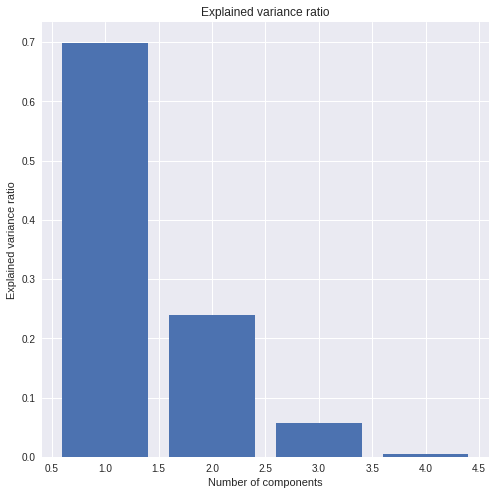

In [11]:
plotExplainedVariance(pca, cumulative=False)

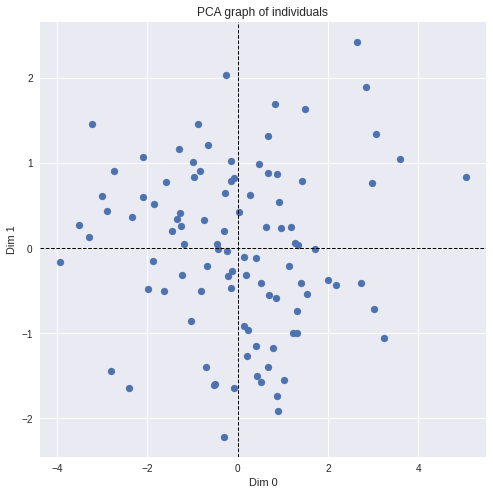

In [12]:
plotIndividuals(comp, [0, 1])

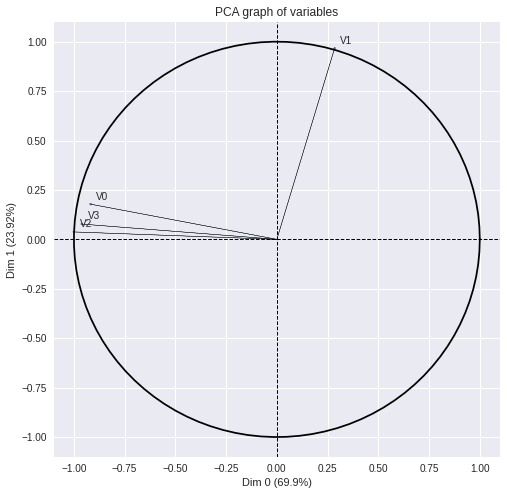

In [13]:
plotVariables(pca)

### NIPALS sans traitement des données manquantes

In [14]:
def NIPALS(X, h=2, iter=100):
    # renvoie les composantes principales (CP), les facteurs principaux (FP) et les données reconstituées avec h composantes (Xrec)
    n, p = X.shape

    # centrer et réduire matrice X
    m = X.mean(axis=0)
    s = X.std(axis=0, ddof=0)
    Xr = (X - m) / s

    # on réserve la place pour:
    CP = np.zeros((n, h))  # les composantes principales
    FP = np.zeros((h, p))  # les facteurs principaux
    Xrec = np.zeros((n, p))  # les données reconstituées

    # déroulement de l'algorithme:
    for i in range(h):
        # voir pages 30-32 du cours
        cp, fp = calcul_cp_fp(Xr, iter)  # fonction qui calcule la 1ere comp. princ et 1er fact. principal
        CP[:, i] = cp
        FP[i, :] = fp
        Xr -= np.matmul(cp.reshape(-1, 1), fp.reshape(1, -1))

    # Reconstitution des données avec h composantes
    Xrec = np.matmul(CP, FP)
    Xrec *= s
    Xrec += m

    return CP, FP, Xrec


def calcul_cp_fp(X, iter=100):
    cp = X[:, 0].copy()
    fp = np.zeros((X.shape[1], ))
    for i in range(iter):
        fp = np.matmul(X.T, cp)

        # on normalize fp:
        fp /= np.sqrt(np.sum(fp**2))
        cp = np.matmul(X, fp)

    return cp, fp

### Application de NIPALS aux données simulées
Voici ce qu'on obtient avec h=4 composantes. À comparer avec ce qui est donné par scikit-learn dans l'objet 'pca'.

In [15]:
cp, fp, Xrec = NIPALS(X, h=p)

Les facteurs principaux :
- nipals

In [16]:
fp

array([[ 0.54407827, -0.16875229,  0.59263506,  0.56946044],
       [ 0.18040406,  0.97972749,  0.03806101,  0.0783567 ],
       [ 0.77938323, -0.0892577 , -0.16706563, -0.5972302 ],
       [ 0.25297231, -0.06074344, -0.78703502,  0.55936671]])

- scikit-learn

In [17]:
pca.components_

array([[-0.54407827,  0.16875229, -0.59263506, -0.56946044],
       [ 0.18040406,  0.97972749,  0.03806101,  0.0783567 ],
       [-0.77938323,  0.0892577 ,  0.16706563,  0.5972302 ],
       [ 0.25297231, -0.06074344, -0.78703502,  0.55936671]])

Les composantes principales :
- nipals

In [18]:
cp[:6, :]

array([[-0.46509805,  0.98837386,  0.3289216 ,  0.11656863],
       [ 3.2287372 ,  1.45664559, -0.03060112, -0.04301417],
       [ 0.08034218,  0.8260302 ,  0.37987793,  0.09327031],
       [-0.20593412, -1.27014213,  0.21036512, -0.13251822],
       [-0.67629184,  0.88410469,  0.43108578, -0.03473332],
       [ 0.28704851,  0.65489962,  0.57269607, -0.0512197 ]])

- scikit-learn

In [19]:
comp[:6, :]

array([[ 0.46509805,  0.98837386, -0.3289216 ,  0.11656863],
       [-3.2287372 ,  1.45664559,  0.03060112, -0.04301417],
       [-0.08034218,  0.8260302 , -0.37987793,  0.09327031],
       [ 0.20593412, -1.27014213, -0.21036512, -0.13251822],
       [ 0.67629184,  0.88410469, -0.43108578, -0.03473332],
       [-0.28704851,  0.65489962, -0.57269607, -0.0512197 ]])

#### La reconstitution complète des données (toutes les composantes principales) 

La reconstitution des données avec toutes les composantes principales.
- Données reconstituées

In [20]:
Xrec[:6, :]

array([[1.23188337, 3.14347085, 3.38747085, 2.78091498],
       [2.68390863, 3.01394039, 7.49967134, 4.42190575],
       [1.47854511, 2.8752649 , 3.94930934, 2.96519088],
       [0.88652465, 0.7900847 , 3.87468799, 2.70999804],
       [1.15626546, 3.07337384, 3.34086297, 2.58239614],
       [1.63844708, 2.6526894 , 4.28874731, 2.89878903]])

- Données

In [21]:
X[:6, :]

array([[1.23188337, 3.14347085, 3.38747085, 2.78091498],
       [2.68390863, 3.01394039, 7.49967134, 4.42190575],
       [1.47854511, 2.8752649 , 3.94930934, 2.96519088],
       [0.88652465, 0.7900847 , 3.87468799, 2.70999804],
       [1.15626546, 3.07337384, 3.34086297, 2.58239614],
       [1.63844708, 2.6526894 , 4.28874731, 2.89878903]])

#### Approximation des données avec quelques composantes (ici h=2)

Voici la reconstitution des données avec juste deux composantes :

In [22]:
cp, fp, Xrec = NIPALS(X, h=2)

- Données reconstituées

In [23]:
Xrec[:6, :]

array([[0.99787074, 3.18191365, 3.63960016, 2.87596954],
       [2.71234221, 3.00830238, 7.4326992 , 4.42609564],
       [1.21684447, 2.91701296, 4.18455463, 3.09172691],
       [0.77974411, 0.80140151, 3.75583487, 2.85468521],
       [0.88840092, 3.11174104, 3.41766147, 2.78294344],
       [1.28364127, 2.70333478, 4.38390676, 3.16727224]])

- Données

In [24]:
X[:6, :]

array([[1.23188337, 3.14347085, 3.38747085, 2.78091498],
       [2.68390863, 3.01394039, 7.49967134, 4.42190575],
       [1.47854511, 2.8752649 , 3.94930934, 2.96519088],
       [0.88652465, 0.7900847 , 3.87468799, 2.70999804],
       [1.15626546, 3.07337384, 3.34086297, 2.58239614],
       [1.63844708, 2.6526894 , 4.28874731, 2.89878903]])

## NIPALS avec données manquantes.
L'algorithme précédent est adapté aux cas où il n'y a pas de données manquantes. Les points à modifier sont au niveau du :

  - calcul des moyennes (m) et écart-types (s)
  - calcul des composantes et facteurs dans la fonction calcul_cp_fp

On ré-écrit donc ces fonctions en les renommant : *NIPALS_dm* et *calcul_cp_fp_dm* 

In [25]:
def NIPALS_dm(X, h=2, iter=100):
    # renvoie les composantes principales (CP), les facteurs principaux (FP) et les données reconstituées avec h composantes (Xrec)
    n, p = X.shape

    # centrer et réduire matrice X
    m = np.nanmean(X, axis=0)
    s = np.nanstd(X, axis=0, ddof=0)
    Xr = (X - m) / s

    # on réserve la place pour:
    CP = np.zeros((n, h))  # les composantes principales
    FP = np.zeros((h, p))  # les facteurs principaux
    Xrec = np.zeros((n, p))  # les données reconstituées

    # déroulement de l'algorithme:
    for i in range(h):
        # voir pages 30-32 du cours
        cp, fp = calcul_cp_fp_dm(Xr, iter)  # fonction qui calcule la 1ere comp. princ et 1er fact. principal
        CP[:, i] = cp
        FP[i, :] = fp
        Xr -= np.matmul(cp.reshape(-1, 1), fp.reshape(1, -1))

    # Reconstitution des données avec h composantes
    Xrec = np.matmul(CP, FP)
    Xrec *= s
    Xrec += m

    return CP, FP, Xrec


def calcul_cp_fp_dm(X, iter=100):
    cp = X[:, 0].copy()
    fp = np.zeros((X.shape[1], ))
    for i in range(iter):
        for j in range(X.shape[1]):
            fp[j] = np.nansum(X[:, j] * cp)

        # on normalize fp:
        fp /= np.sqrt(np.sum(fp**2))

        for j in range(X.shape[0]):
            cp[j] = np.nansum(X[j, :] * fp)

    return cp, fp

On vérifie que la version modifiée *NIPALS_dm* donne les mêmes résultats que *NIPALS* lorsqu'il n'y a pas données manquantes. 

In [26]:
cp_dm, fp_dm, Xrec_dm = NIPALS_dm(X, h = p)
cp, fp, Xrec = NIPALS(X, h = p)

Les facteurs principaux :

In [27]:
fp_dm

array([[ 0.54407827, -0.16875229,  0.59263506,  0.56946044],
       [ 0.18040406,  0.97972749,  0.03806101,  0.0783567 ],
       [ 0.77938323, -0.0892577 , -0.16706563, -0.5972302 ],
       [ 0.25297231, -0.06074344, -0.78703502,  0.55936671]])

In [28]:
fp

array([[ 0.54407827, -0.16875229,  0.59263506,  0.56946044],
       [ 0.18040406,  0.97972749,  0.03806101,  0.0783567 ],
       [ 0.77938323, -0.0892577 , -0.16706563, -0.5972302 ],
       [ 0.25297231, -0.06074344, -0.78703502,  0.55936671]])

Les composantes principales :

In [29]:
cp_dm[:6, :]

array([[-0.46509805,  0.98837386,  0.3289216 ,  0.11656863],
       [ 3.2287372 ,  1.45664559, -0.03060112, -0.04301417],
       [ 0.08034218,  0.8260302 ,  0.37987793,  0.09327031],
       [-0.20593412, -1.27014213,  0.21036512, -0.13251822],
       [-0.67629184,  0.88410469,  0.43108578, -0.03473332],
       [ 0.28704851,  0.65489962,  0.57269607, -0.0512197 ]])

In [30]:
cp[:6, :]

array([[-0.46509805,  0.98837386,  0.3289216 ,  0.11656863],
       [ 3.2287372 ,  1.45664559, -0.03060112, -0.04301417],
       [ 0.08034218,  0.8260302 ,  0.37987793,  0.09327031],
       [-0.20593412, -1.27014213,  0.21036512, -0.13251822],
       [-0.67629184,  0.88410469,  0.43108578, -0.03473332],
       [ 0.28704851,  0.65489962,  0.57269607, -0.0512197 ]])

Les données reconstituées :

In [31]:
Xrec_dm[:6, :]

array([[1.23188337, 3.14347085, 3.38747085, 2.78091498],
       [2.68390863, 3.01394039, 7.49967134, 4.42190575],
       [1.47854511, 2.8752649 , 3.94930934, 2.96519088],
       [0.88652465, 0.7900847 , 3.87468799, 2.70999804],
       [1.15626546, 3.07337384, 3.34086297, 2.58239614],
       [1.63844708, 2.6526894 , 4.28874731, 2.89878903]])

In [32]:
Xrec[:6, :]

array([[1.23188337, 3.14347085, 3.38747085, 2.78091498],
       [2.68390863, 3.01394039, 7.49967134, 4.42190575],
       [1.47854511, 2.8752649 , 3.94930934, 2.96519088],
       [0.88652465, 0.7900847 , 3.87468799, 2.70999804],
       [1.15626546, 3.07337384, 3.34086297, 2.58239614],
       [1.63844708, 2.6526894 , 4.28874731, 2.89878903]])

Parfait!

### Simulation des données manquantes sur la matrice X


In [33]:
# pourcentage des données manquantes
pm = 0.1
# génération des valeurs manquantes
Xm = X.copy()
ind = rng.random((n, p))
im = ind < pm
Xm[im] = np.nan

Nombre de manquants par colonne :

In [34]:
np.isnan(Xm).sum(axis=0)

array([ 9,  6, 20, 11])

Voici les valeurs qui ont été déclarées manquantes :

In [35]:
X[im]

array([ 3.01394039,  7.49967134,  4.42190575,  0.88652465,  3.34086297,
        1.77750098,  4.80741826,  4.23619526, -0.10588813,  4.96592085,
        2.2224621 ,  4.57506364,  3.5085072 ,  3.41285513,  3.06144548,
        1.46074951,  2.11144813,  3.2752856 ,  1.20344408,  2.76090799,
        3.31289671,  0.30332669,  3.06252788,  3.52716513,  5.64925906,
        0.7972992 ,  1.92393853,  0.56638218,  3.09186486,  4.07118995,
        0.20240732,  2.32633613,  1.4963125 ,  3.9421519 , -1.00301296,
        1.93548331,  7.97703491,  1.23682406,  0.0760175 ,  4.14315011,
        3.64241138,  4.06142202,  4.37938677,  0.11648195,  4.75510937,
        3.20818419])

### Imputation des valeurs manquantes avec NIPALS :

In [36]:
cp_imp, fp_imp, Xrec_imp = NIPALS_dm(Xm, p)

Voici les valeurs estimées par NIPALS pour les données manquantes :

In [37]:
Xrec_imp[im]

array([2.00229811, 5.11740942, 3.05275806, 1.02413029, 3.52078876,
       1.12755762, 4.34855052, 4.23727022, 0.75330718, 4.23114253,
       1.7195988 , 4.46595893, 3.60688626, 3.32304999, 3.98911965,
       1.47808294, 2.62737357, 1.88747632, 1.98684858, 2.84081005,
       3.38754992, 1.04353445, 3.63144683, 4.13132113, 4.92891952,
       2.2980935 , 2.22637766, 1.05566221, 3.72923277, 4.29268786,
       2.25385361, 2.79789539, 2.34114609, 3.69796831, 0.52243915,
       2.56326625, 6.88000467, 2.11493625, 1.72556401, 3.53238024,
       3.60190471, 2.00595822, 4.34700247, 1.04688325, 4.40951451,
       3.04497695])

Cela a l'air pas mal!